In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from matplotlib import cm
from pyflann import *
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import roc_curve, auc
import cv2
import csv
import re

# %matplotlib notebook

coordinate_header = ['FrameNumber', 'MouthHook_x', 'MouthHook_y', 'LeftMHhook_x', 'LeftMHhook_y',
                     'RightMHhook_x', 'RightMHhook_y', 'LeftDorsalOrgan_x', 'LeftDorsalOrgan_y',
                     'RightDorsalOrgan_x', 'RightDorsalOrgan_y', 'CenterBolwigOrgan_x', 'CenterBolwigOrgan_y',
                     'LeftBolwigOrgan_x', 'LeftBolwigOrgan_y', 'RightBolwigOrgan_x', 'RightBolwigOrgan_y']


distance_header = ['MouthHook', 'LeftMHhook',
                   'RightMHhook', 'LeftDorsalOrgan', 'RightDorsalOrgan',
                   'CenterBolwigOrgan', 'LeftBolwigOrgan', 'RightBolwigOrgan']


def saveTrainTableVariants(test_dir_2, fs2, variant_conditions):
    train_table_file = os.path.join(test_dir_2, fs2)
    train_table = pd.read_csv(train_table_file, sep='\t', header=None)

    for cond in variant_conditions:

        # Only MouthHook
        if cond == 'MouthHook':
            temp_dat = train_table.loc[train_table.loc[:, 131] == 1, :].copy()

        # Only Left MouthHook
        if cond == 'LeftMHhook':
            temp_dat = train_table.loc[train_table.loc[:, 134] == 1, :].copy()

        # Only Right MouthHook
        if cond == 'RightMHhook':
            temp_dat = train_table.loc[train_table.loc[:, 137] == 1, :].copy()

        # Only Left Dorsal Organ
        if cond == 'LeftDorsalOrgan':
            temp_dat = train_table.loc[train_table.loc[:, 140] == 1, :].copy()

        # Only Right Dorsal Organ
        if cond == 'RightDorsalOrgan':
            temp_dat = train_table.loc[train_table.loc[:, 143] == 1, :].copy()

        # Only Both DO
        if cond == 'BothDorsalOrganPresent':
            temp_dat = train_table.loc[(train_table.loc[:, 140] == 1) & (
                train_table.loc[:, 143] == 1), :].copy()

        # Only Both DO Removed Neg From Pos
        if cond == 'BothDorsalOrganNegPos':
            temp_pos = train_table.loc[(train_table.loc[:, 140] == 1) & (
                train_table.loc[:, 143] == 1), :].copy()
            temp_neg = train_table.loc[(train_table.loc[:, 140] == 0) | (
                train_table.loc[:, 143] == 0), :].copy()

        var_train_table_file = os.path.join(
            test_dir_2, fs2[:-4]+'_'+cond+'.txt')
        temp_dat.sort_values(0, inplace=True)
        temp_dat.to_csv(var_train_table_file, sep=',',
                        header=False, index=False)

        
def readFPGA_KP_DescfromFile(kp_file, desc_file):
    ## Read Keypoints
    keypoints = []
    with open(kp_file, 'r') as csvfile:
        csvreader = csv.reader(csvfile, delimiter=',')
        for row in csvreader:
            row = [[float(val) for val in ro.strip().split('\t')] for ro in row]
            row = row[0]
            keypoints_temp = cv2.KeyPoint(x=float(row[0]), y=float(row[1]),
                                          _size=float((float(row[2]) / float(1.2)) * float(9)),
                                          _angle=float(2*np.pi - float(row[6])), _response=float(row[3]),
                                          _octave=int(row[4]), _class_id=int(row[5]))
            keypoints.append(keypoints_temp)

    ## Read Descriptors
    descriptors = []
    with open(desc_file, 'r') as csvfile:
        csvreader = csv.reader(csvfile, delimiter=',')
        for row in csvreader:
            row = [[float(val) for val in ro.strip().split('\t')] for ro in row]
            row = row[0]
            descriptors.append(row)

    return keypoints, descriptors


def get_train_data(train_pos):
    train_data = {}
    train_data['descriptors'] = np.array(train_pos.loc[:, 1:128].values, dtype=np.float32)
    train_data['votes'] = {}
    for bp_ind, bp in enumerate(distance_header):
        train_data['votes'][bp] = np.array(train_pos.loc[:, 129+(bp_ind*3):130+(bp_ind*3)].values, dtype=np.float32)
        
    return train_data

def predict_locations_patchsize(train_data, test_annotations, vote_patch_size, vote_sigma):
    bodypart_knn_pos = FLANN()
    bodypart_knn_pos.build_index(train_data['descriptors'])
    frame_index = 0
    detect_bodypart = distance_header
    bodypart_gt = {}
    crop_size = 256
#     vote_patch_size = 30
#     vote_sigma = 5
    bodypart_vote = np.zeros(
        (2 * vote_patch_size + 1, 2 * vote_patch_size + 1), np.float)
    for x in range(-vote_patch_size, vote_patch_size + 1):
        for y in range(-vote_patch_size, vote_patch_size + 1):
            bodypart_vote[y + vote_patch_size, x + vote_patch_size] = 1.0 + np.exp(-0.5 * (
                x * x + y * y) / (np.square(vote_sigma))) / (vote_sigma * np.sqrt(2 * np.pi))

    cols = [[bp+'_x', bp+'_y']  for bp in distance_header] + [[bp+'_votes'] for bp in distance_header]
    cols = [item for sublist in cols for item in sublist]
    detected_loc = pd.DataFrame([], columns=cols)

    for j in range(0, len(test_annotations)):
        frame_index += 1
        annotation = test_annotations[j]

        frame_file = annotation["FrameFile"]
        frame_file = re.sub(".*/data/", "data/", frame_file.strip())
        frame_file = project_dir + frame_file
        frame = cv2.imread(frame_file)

        flag_skip = True
        bodypart_coords_gt = {}
        for k in range(0, len(annotation["FrameValueCoordinates"])):
            bi = annotation["FrameValueCoordinates"][k]["Name"]
            if ((bi == "MouthHook" or any(bi == s for s in detect_bodypart)) and annotation["FrameValueCoordinates"][k]["Value"]["x_coordinate"] != -1 and annotation["FrameValueCoordinates"][k]["Value"]["y_coordinate"] != -1):
                flag_skip = False
                bodypart_coords_gt[bi] = {}
                bodypart_coords_gt[bi]["x"] = int(
                    annotation["FrameValueCoordinates"][k]["Value"]["x_coordinate"])
                bodypart_coords_gt[bi]["y"] = int(
                    annotation["FrameValueCoordinates"][k]["Value"]["y_coordinate"])

        bodypart_gt[frame_index] = {}
        bodypart_gt[frame_index]["bodypart_coords_gt"] = bodypart_coords_gt
        bodypart_gt[frame_index]["frame_file"] = frame_file

        if "MouthHook" in bodypart_gt[frame_index]["bodypart_coords_gt"]:
            crop_x = max(
                0, bodypart_gt[frame_index]["bodypart_coords_gt"]["MouthHook"]["x"]-int(crop_size/2))
            crop_y = max(
                0, bodypart_gt[frame_index]["bodypart_coords_gt"]["MouthHook"]["y"]-int(crop_size/2))

            frame = frame[crop_y:crop_y+crop_size, crop_x:crop_x+crop_size, 0]
            image_info = np.shape(frame)
            bodypart_vote_map = {}
            for bp in detect_bodypart:
                bodypart_vote_map[bp] = np.zeros((np.shape(frame)[0], np.shape(frame)[1]), np.float)

            # Read Keypoints
            current_dir = os.path.abspath(os.path.dirname(frame_file))
            parent_dir = os.path.basename(current_dir)
            keypoints_folder = os.path.join(dir_keypoints, parent_dir)
            if not os.path.exists(keypoints_folder):
                print "Folder does not exist !!!"
            keypoints_file = os.path.join(keypoints_folder, os.path.splitext(os.path.basename(annotation["FrameFile"]))[0]) + ".csv"
            if not os.path.exists(keypoints_file):
                print "%s does not exist !!!" % (keypoints_file)
                continue

            # Read Descriptors
            current_dir = os.path.abspath(os.path.dirname(frame_file))
            parent_dir = os.path.basename(current_dir)
            descriptors_folder = os.path.join(dir_descriptors, parent_dir)
            if not os.path.exists(descriptors_folder):
                print "Folder does not exist !!!"

            descriptors_file = os.path.join(descriptors_folder, os.path.splitext(os.path.basename(annotation["FrameFile"]))[0]) + ".csv"
            if not os.path.exists(descriptors_file):
                print "%s does not exist !!!" % (descriptors_file)
                continue

            kp_frame, desc_frame = readFPGA_KP_DescfromFile(keypoints_file, descriptors_file)

            if desc_frame is not None:
                for h, desc in enumerate(desc_frame):
                    desc = np.array(desc, np.float32).reshape((1, 128))
                    r_pos, d_pos = bodypart_knn_pos.nn_index(desc, 1, check=16)
                    a = kp_frame[h].angle
                    R = np.array([[np.cos(a), -np.sin(a)], [np.sin(a), np.cos(a)]])

                    for bp in detect_bodypart:
                        vote_loc = train_data['votes'][bp][r_pos, :]
                        p = kp_frame[h].pt + np.dot(R, vote_loc[0])
                        x, y = p
                        if (not ((x <= vote_patch_size) | (x >= np.shape(frame)[1] - vote_patch_size) |  (y <= vote_patch_size) | (y >= np.shape(frame)[0] - vote_patch_size))):
                            y_start = int(float(y)) - int(float(vote_patch_size))
                            y_end = int(float(y)) + int(float(vote_patch_size) + 1.0)
                            x_start = int(float(x)) - int(float(vote_patch_size))
                            x_end = int(float(x)) + int(float(vote_patch_size) + 1.0)
                            bodypart_vote_map[bp][y_start:y_end, x_start:x_end] += bodypart_vote

            for bp in detect_bodypart:
                vote_max = np.amax(bodypart_vote_map[bp][:, :])
                vote_max_loc = np.array(np.where(bodypart_vote_map[bp][:, :] == vote_max))
                detected_loc.loc[int(annotation['FrameID']), [bp+'_x', bp+'_y']] = vote_max_loc[:, 0].copy() + [crop_x, crop_y]
                detected_loc.loc[int(annotation['FrameID']), [bp+'_votes']] = vote_max

        else:
            continue

    detected_loc.index.name = 'FrameNumber'
    
    del bodypart_knn_pos

    return detected_loc


def predict_locations(train_data, test_annotations):
    bodypart_knn_pos = FLANN()
    bodypart_knn_pos.build_index(train_data['descriptors'])
    frame_index = 0
    detect_bodypart = distance_header
    bodypart_gt = {}
    crop_size = 256
    vote_patch_size = 7
    vote_sigma = 5
    bodypart_vote = np.zeros(
        (2 * vote_patch_size + 1, 2 * vote_patch_size + 1), np.float)
    for x in range(-vote_patch_size, vote_patch_size + 1):
        for y in range(-vote_patch_size, vote_patch_size + 1):
            bodypart_vote[y + vote_patch_size, x + vote_patch_size] = 1.0 + np.exp(-0.5 * (
                x * x + y * y) / (np.square(vote_sigma))) / (vote_sigma * np.sqrt(2 * np.pi))

    cols = [[bp+'_x', bp+'_y']  for bp in distance_header] + [[bp+'_votes'] for bp in distance_header]
    cols = [item for sublist in cols for item in sublist]
    detected_loc = pd.DataFrame([], columns=cols)

    for j in range(0, len(test_annotations)):
        frame_index += 1
        annotation = test_annotations[j]

        frame_file = annotation["FrameFile"]
        frame_file = re.sub(".*/data/", "data/", frame_file.strip())
        frame_file = project_dir + frame_file
        frame = cv2.imread(frame_file)

        flag_skip = True
        bodypart_coords_gt = {}
        for k in range(0, len(annotation["FrameValueCoordinates"])):
            bi = annotation["FrameValueCoordinates"][k]["Name"]
            if ((bi == "MouthHook" or any(bi == s for s in detect_bodypart)) and annotation["FrameValueCoordinates"][k]["Value"]["x_coordinate"] != -1 and annotation["FrameValueCoordinates"][k]["Value"]["y_coordinate"] != -1):
                flag_skip = False
                bodypart_coords_gt[bi] = {}
                bodypart_coords_gt[bi]["x"] = int(
                    annotation["FrameValueCoordinates"][k]["Value"]["x_coordinate"])
                bodypart_coords_gt[bi]["y"] = int(
                    annotation["FrameValueCoordinates"][k]["Value"]["y_coordinate"])

        bodypart_gt[frame_index] = {}
        bodypart_gt[frame_index]["bodypart_coords_gt"] = bodypart_coords_gt
        bodypart_gt[frame_index]["frame_file"] = frame_file

        if "MouthHook" in bodypart_gt[frame_index]["bodypart_coords_gt"]:
            crop_x = max(
                0, bodypart_gt[frame_index]["bodypart_coords_gt"]["MouthHook"]["x"]-int(crop_size/2))
            crop_y = max(
                0, bodypart_gt[frame_index]["bodypart_coords_gt"]["MouthHook"]["y"]-int(crop_size/2))

            frame = frame[crop_y:crop_y+crop_size, crop_x:crop_x+crop_size, 0]
            image_info = np.shape(frame)
            bodypart_vote_map = {}
            for bp in detect_bodypart:
                bodypart_vote_map[bp] = np.zeros((np.shape(frame)[0], np.shape(frame)[1]), np.float)

            # Read Keypoints
            current_dir = os.path.abspath(os.path.dirname(frame_file))
            parent_dir = os.path.basename(current_dir)
            keypoints_folder = os.path.join(dir_keypoints, parent_dir)
            if not os.path.exists(keypoints_folder):
                print "Folder does not exist !!!"
            keypoints_file = os.path.join(keypoints_folder, os.path.splitext(os.path.basename(annotation["FrameFile"]))[0]) + ".csv"
            if not os.path.exists(keypoints_file):
                print "%s does not exist !!!" % (keypoints_file)
                continue

            # Read Descriptors
            current_dir = os.path.abspath(os.path.dirname(frame_file))
            parent_dir = os.path.basename(current_dir)
            descriptors_folder = os.path.join(dir_descriptors, parent_dir)
            if not os.path.exists(descriptors_folder):
                print "Folder does not exist !!!"

            descriptors_file = os.path.join(descriptors_folder, os.path.splitext(os.path.basename(annotation["FrameFile"]))[0]) + ".csv"
            if not os.path.exists(descriptors_file):
                print "%s does not exist !!!" % (descriptors_file)
                continue

            kp_frame, desc_frame = readFPGA_KP_DescfromFile(keypoints_file, descriptors_file)

            if desc_frame is not None:
                for h, desc in enumerate(desc_frame):
                    desc = np.array(desc, np.float32).reshape((1, 128))
                    r_pos, d_pos = bodypart_knn_pos.nn_index(desc, 1, check=16)
                    a = kp_frame[h].angle
                    R = np.array([[np.cos(a), -np.sin(a)], [np.sin(a), np.cos(a)]])

                    for bp in detect_bodypart:
                        vote_loc = train_data['votes'][bp][r_pos, :]
                        p = kp_frame[h].pt + np.dot(R, vote_loc[0])
                        x, y = p
                        if (not ((x <= vote_patch_size) | (x >= np.shape(frame)[1] - vote_patch_size) |  (y <= vote_patch_size) | (y >= np.shape(frame)[0] - vote_patch_size))):
                            y_start = int(float(y)) - int(float(vote_patch_size))
                            y_end = int(float(y)) + int(float(vote_patch_size) + 1.0)
                            x_start = int(float(x)) - int(float(vote_patch_size))
                            x_end = int(float(x)) + int(float(vote_patch_size) + 1.0)
                            bodypart_vote_map[bp][y_start:y_end, x_start:x_end] += bodypart_vote

            for bp in detect_bodypart:
                vote_max = np.amax(bodypart_vote_map[bp][:, :])
                vote_max_loc = np.array(np.where(bodypart_vote_map[bp][:, :] == vote_max))
                detected_loc.loc[int(annotation['FrameID']), [bp+'_x', bp+'_y']] = vote_max_loc[:, 0].copy() + [crop_x, crop_y]
                detected_loc.loc[int(annotation['FrameID']), [bp+'_votes']] = vote_max

        else:
            continue

    detected_loc.index.name = 'FrameNumber'
    
    del bodypart_knn_pos

    return detected_loc


def predict_locations_neg_pos(train_data_pos, train_data_neg, test_annotations):
    bodypart_knn_pos = FLANN()
    bodypart_knn_pos.build_index(train_data_pos['descriptors'])
    bodypart_knn_neg = FLANN()
    bodypart_knn_neg.build_index(train_data_neg['descriptors'])
    rel_dist_all = []
    
    frame_index = 0
    detect_bodypart = distance_header
    bodypart_gt = {}
    crop_size = 256
    vote_patch_size = 7
    vote_sigma = 5
    bodypart_vote = np.zeros(
        (2 * vote_patch_size + 1, 2 * vote_patch_size + 1), np.float)
    for x in range(-vote_patch_size, vote_patch_size + 1):
        for y in range(-vote_patch_size, vote_patch_size + 1):
            bodypart_vote[y + vote_patch_size, x + vote_patch_size] = 1.0 + np.exp(-0.5 * (
                x * x + y * y) / (np.square(vote_sigma))) / (vote_sigma * np.sqrt(2 * np.pi))

    cols = [[bp+'_x', bp+'_y']  for bp in distance_header] + [[bp+'_votes'] for bp in distance_header]
    cols = [item for sublist in cols for item in sublist]
    detected_loc = pd.DataFrame([], columns=cols)

    for j in range(0, len(test_annotations)):
        frame_index += 1
        annotation = test_annotations[j]

        frame_file = annotation["FrameFile"]
        frame_file = re.sub(".*/data/", "data/", frame_file.strip())
        frame_file = project_dir + frame_file
        frame = cv2.imread(frame_file)

        flag_skip = True
        bodypart_coords_gt = {}
        for k in range(0, len(annotation["FrameValueCoordinates"])):
            bi = annotation["FrameValueCoordinates"][k]["Name"]
            if ((bi == "MouthHook" or any(bi == s for s in detect_bodypart)) and annotation["FrameValueCoordinates"][k]["Value"]["x_coordinate"] != -1 and annotation["FrameValueCoordinates"][k]["Value"]["y_coordinate"] != -1):
                flag_skip = False
                bodypart_coords_gt[bi] = {}
                bodypart_coords_gt[bi]["x"] = int(
                    annotation["FrameValueCoordinates"][k]["Value"]["x_coordinate"])
                bodypart_coords_gt[bi]["y"] = int(
                    annotation["FrameValueCoordinates"][k]["Value"]["y_coordinate"])

        bodypart_gt[frame_index] = {}
        bodypart_gt[frame_index]["bodypart_coords_gt"] = bodypart_coords_gt
        bodypart_gt[frame_index]["frame_file"] = frame_file

        if "MouthHook" in bodypart_gt[frame_index]["bodypart_coords_gt"]:
            crop_x = max(
                0, bodypart_gt[frame_index]["bodypart_coords_gt"]["MouthHook"]["x"]-int(crop_size/2))
            crop_y = max(
                0, bodypart_gt[frame_index]["bodypart_coords_gt"]["MouthHook"]["y"]-int(crop_size/2))

            frame = frame[crop_y:crop_y+crop_size, crop_x:crop_x+crop_size, 0]
            image_info = np.shape(frame)
            bodypart_vote_map = {}
            for bp in detect_bodypart:
                bodypart_vote_map[bp] = np.zeros((np.shape(frame)[0], np.shape(frame)[1]), np.float)

            # Read Keypoints
            current_dir = os.path.abspath(os.path.dirname(frame_file))
            parent_dir = os.path.basename(current_dir)
            keypoints_folder = os.path.join(dir_keypoints, parent_dir)
            if not os.path.exists(keypoints_folder):
                print "Folder does not exist !!!"
            keypoints_file = os.path.join(keypoints_folder, os.path.splitext(os.path.basename(annotation["FrameFile"]))[0]) + ".csv"
            if not os.path.exists(keypoints_file):
                print "%s does not exist !!!" % (keypoints_file)
                continue

            # Read Descriptors
            current_dir = os.path.abspath(os.path.dirname(frame_file))
            parent_dir = os.path.basename(current_dir)
            descriptors_folder = os.path.join(dir_descriptors, parent_dir)
            if not os.path.exists(descriptors_folder):
                print "Folder does not exist !!!"

            descriptors_file = os.path.join(descriptors_folder, os.path.splitext(os.path.basename(annotation["FrameFile"]))[0]) + ".csv"
            if not os.path.exists(descriptors_file):
                print "%s does not exist !!!" % (descriptors_file)
                continue

            kp_frame, desc_frame = readFPGA_KP_DescfromFile(keypoints_file, descriptors_file)
            if desc_frame is not None:
                for h, desc in enumerate(desc_frame):
                    desc = np.array(desc, np.float32).reshape((1, 128))
                    r_pos, d_pos = bodypart_knn_pos.nn_index(desc, 1, check=16)
                    r_neg, d_neg = bodypart_knn_neg.nn_index(desc, 1, check=16)
                    rel_dist = r_pos - r_neg
                    rel_dist_all.append(rel_dist)
                    if (rel_dist < 0):
                        a = kp_frame[h].angle
                        R = np.array([[np.cos(a), -np.sin(a)], [np.sin(a), np.cos(a)]])

                        for bp in detect_bodypart:
                            vote_loc = train_data_pos['votes'][bp][r_pos, :]
                            p = kp_frame[h].pt + np.dot(R, vote_loc[0])
                            x, y = p
                            if (not ((x <= vote_patch_size) | (x >= np.shape(frame)[1] - vote_patch_size) |  (y <= vote_patch_size) | (y >= np.shape(frame)[0] - vote_patch_size))):
                                y_start = int(float(y)) - int(float(vote_patch_size))
                                y_end = int(float(y)) + int(float(vote_patch_size) + 1.0)
                                x_start = int(float(x)) - int(float(vote_patch_size))
                                x_end = int(float(x)) + int(float(vote_patch_size) + 1.0)
                                bodypart_vote_map[bp][y_start:y_end, x_start:x_end] += bodypart_vote

            for bp in detect_bodypart:
                vote_max = np.amax(bodypart_vote_map[bp][:, :])
                vote_max_loc = np.array(np.where(bodypart_vote_map[bp][:, :] == vote_max))
                detected_loc.loc[int(annotation['FrameID']), [bp+'_x', bp+'_y']] = vote_max_loc[:, 0].copy() + [crop_x, crop_y]
                detected_loc.loc[int(annotation['FrameID']), [bp+'_votes']] = vote_max

        else:
            continue

    detected_loc.index.name = 'FrameNumber'
    
    del bodypart_knn_pos

    return detected_loc


def predict_locations_ratio_test(train_data_pos, test_annotations):
    bodypart_knn_pos = FLANN()
    bodypart_knn_pos.build_index(train_data_pos['descriptors'])
    
    frame_index = 0
    detect_bodypart = distance_header
    bodypart_gt = {}
    crop_size = 256
    vote_patch_size = 7
    vote_sigma = 5
    bodypart_vote = np.zeros(
        (2 * vote_patch_size + 1, 2 * vote_patch_size + 1), np.float)
    for x in range(-vote_patch_size, vote_patch_size + 1):
        for y in range(-vote_patch_size, vote_patch_size + 1):
            bodypart_vote[y + vote_patch_size, x + vote_patch_size] = 1.0 + np.exp(-0.5 * (
                x * x + y * y) / (np.square(vote_sigma))) / (vote_sigma * np.sqrt(2 * np.pi))

    cols = [[bp+'_x', bp+'_y']  for bp in distance_header] + [[bp+'_votes'] for bp in distance_header]
    cols = [item for sublist in cols for item in sublist]
    detected_loc = pd.DataFrame([], columns=cols)

    for j in range(0, len(test_annotations)):
        frame_index += 1
        annotation = test_annotations[j]

        frame_file = annotation["FrameFile"]
        frame_file = re.sub(".*/data/", "data/", frame_file.strip())
        frame_file = project_dir + frame_file
        frame = cv2.imread(frame_file)

        flag_skip = True
        bodypart_coords_gt = {}
        for k in range(0, len(annotation["FrameValueCoordinates"])):
            bi = annotation["FrameValueCoordinates"][k]["Name"]
            if ((bi == "MouthHook" or any(bi == s for s in detect_bodypart)) and annotation["FrameValueCoordinates"][k]["Value"]["x_coordinate"] != -1 and annotation["FrameValueCoordinates"][k]["Value"]["y_coordinate"] != -1):
                flag_skip = False
                bodypart_coords_gt[bi] = {}
                bodypart_coords_gt[bi]["x"] = int(
                    annotation["FrameValueCoordinates"][k]["Value"]["x_coordinate"])
                bodypart_coords_gt[bi]["y"] = int(
                    annotation["FrameValueCoordinates"][k]["Value"]["y_coordinate"])

        bodypart_gt[frame_index] = {}
        bodypart_gt[frame_index]["bodypart_coords_gt"] = bodypart_coords_gt
        bodypart_gt[frame_index]["frame_file"] = frame_file

        if "MouthHook" in bodypart_gt[frame_index]["bodypart_coords_gt"]:
            crop_x = max(
                0, bodypart_gt[frame_index]["bodypart_coords_gt"]["MouthHook"]["x"]-int(crop_size/2))
            crop_y = max(
                0, bodypart_gt[frame_index]["bodypart_coords_gt"]["MouthHook"]["y"]-int(crop_size/2))

            frame = frame[crop_y:crop_y+crop_size, crop_x:crop_x+crop_size, 0]
            image_info = np.shape(frame)
            bodypart_vote_map = {}
            for bp in detect_bodypart:
                bodypart_vote_map[bp] = np.zeros((np.shape(frame)[0], np.shape(frame)[1]), np.float)

            # Read Keypoints
            current_dir = os.path.abspath(os.path.dirname(frame_file))
            parent_dir = os.path.basename(current_dir)
            keypoints_folder = os.path.join(dir_keypoints, parent_dir)
            if not os.path.exists(keypoints_folder):
                print "Folder does not exist !!!"
            keypoints_file = os.path.join(keypoints_folder, os.path.splitext(os.path.basename(annotation["FrameFile"]))[0]) + ".csv"
            if not os.path.exists(keypoints_file):
                print "%s does not exist !!!" % (keypoints_file)
                continue

            # Read Descriptors
            current_dir = os.path.abspath(os.path.dirname(frame_file))
            parent_dir = os.path.basename(current_dir)
            descriptors_folder = os.path.join(dir_descriptors, parent_dir)
            if not os.path.exists(descriptors_folder):
                print "Folder does not exist !!!"

            descriptors_file = os.path.join(descriptors_folder, os.path.splitext(os.path.basename(annotation["FrameFile"]))[0]) + ".csv"
            if not os.path.exists(descriptors_file):
                print "%s does not exist !!!" % (descriptors_file)
                continue

            kp_frame, desc_frame = readFPGA_KP_DescfromFile(keypoints_file, descriptors_file)
            if desc_frame is not None:
                for h, desc in enumerate(desc_frame):
                    desc = np.array(desc, np.float32).reshape((1, 128))
                    r_pos, d_pos = bodypart_knn_pos.nn_index(desc, 2, check=50)
                    r_pos = np.squeeze(r_pos)
                    d_pos = np.squeeze(d_pos)
                    if d_pos[0] < (0.9*d_pos[1]):
                        a = kp_frame[h].angle
                        R = np.array([[np.cos(a), -np.sin(a)], [np.sin(a), np.cos(a)]])

                        for bp in detect_bodypart:
                            vote_loc = train_data_pos['votes'][bp][r_pos[0], :]
                            p = kp_frame[h].pt + np.dot(R, vote_loc)
                            x, y = p
                            if (not ((x <= vote_patch_size) | (x >= np.shape(frame)[1] - vote_patch_size) |  (y <= vote_patch_size) | (y >= np.shape(frame)[0] - vote_patch_size))):
                                y_start = int(float(y)) - int(float(vote_patch_size))
                                y_end = int(float(y)) + int(float(vote_patch_size) + 1.0)
                                x_start = int(float(x)) - int(float(vote_patch_size))
                                x_end = int(float(x)) + int(float(vote_patch_size) + 1.0)
                                bodypart_vote_map[bp][y_start:y_end, x_start:x_end] += bodypart_vote

            for bp in detect_bodypart:
                vote_max = np.amax(bodypart_vote_map[bp][:, :])
                vote_max_loc = np.array(np.where(bodypart_vote_map[bp][:, :] == vote_max))
                detected_loc.loc[int(annotation['FrameID']), [bp+'_x', bp+'_y']] = vote_max_loc[:, 0].copy() + [crop_x, crop_y]
                detected_loc.loc[int(annotation['FrameID']), [bp+'_votes']] = vote_max

        else:
            continue

    detected_loc.index.name = 'FrameNumber'
    
    del bodypart_knn_pos

    return detected_loc


def plot_roc_curve(coordinates, detected_loc, bp2, no_anno_df):
    detect_loc_ind = detected_loc.index.values
    dist = pd.DataFrame([], index=detect_loc_ind, columns=distance_header)
    for bp in distance_header:
        temp_x = (detected_loc[bp2+'_x'].astype(np.int64).values - coordinates.loc[detect_loc_ind, bp2+'_x'].astype(np.int64).values)**2
        temp_y = (detected_loc[bp2+'_y'].astype(np.int64).values - coordinates.loc[detect_loc_ind, bp2+'_y'].astype(np.int64).values)**2
        dist.loc[:, bp2] = np.sqrt(temp_x + temp_y)

    ground_truth = detected_loc.iloc[:, 17:].astype(dtype=np.uint16).copy()
    ground_truth.loc[:, :] = 1
    for rind, rval in no_anno_df.iterrows():
        dist.loc[rval['index'], rval['col']] = np.nan
        if rval['index'] in detected_loc.index.values:
            ground_truth.loc[rval['index'], rval['col']+'_votes'] = 0
    votes = detected_loc.iloc[:, 17:].astype(dtype=np.float32).copy()
    fpr, tpr, thresholds = roc_curve(ground_truth[bp2+'_votes'], votes[bp2+'_votes'])
    roc_auc = auc(fpr, tpr)

    return ground_truth, fpr, tpr, thresholds, roc_auc

def plot_roc_curve_and(coordinates, detected_loc, no_anno_df):
    ground_truth = detected_loc.iloc[:, 17:].astype(dtype=np.uint16).copy()
    ground_truth.loc[:, :] = 1
    for rind, rval in no_anno_df.iterrows():
        if rval['index'] in detected_loc.index.values:
            ground_truth.loc[rval['index'], rval['col']+'_votes'] = 0
    votes = detected_loc.iloc[:, 17:].astype(dtype=np.float32).copy()
    votes_use = np.amax([votes.loc[:, 'LeftDorsalOrgan_votes'].copy(), votes.loc[:, 'RightDorsalOrgan_votes'].copy()], axis=0)
    fpr, tpr, thresholds = roc_curve(ground_truth['LeftDorsalOrgan_votes'], votes_use)
    roc_auc = auc(fpr, tpr)

    return ground_truth, fpr, tpr, thresholds, roc_auc



In [2]:
root = '../expts/'
# exp = '20180417_re2_7c1_Hess_50'
# exp = '20180417_re2_7c1_Hess_50_Nbr_100'
exp = '20180417_re2_7c1_Hess_25_Nbr_100'

test_list = [('dataCollectedOn_20180417_grp_1/Rawdata_20180417_084502_075225_A_073456/', "Rawdata_20180417_084502"),
             ('dataCollectedOn_20180417_grp_2/Rawdata_20180417_083618_104633_A_064042/', "Rawdata_20180417_083618"),
             ('dataCollectedOn_20180417_grp_3/Rawdata_20180417_082627_112343_A_133410_A_130926/', "Rawdata_20180417_082627"),
             ('dataCollectedOn_20180417_grp_4/Rawdata_20180417_075246_20180420_092232_A_095851/', "Rawdata_20180417_075246"),
             ('dataCollectedOn_20180417_grp_5/Rawdata_20180417_072307_100127_A_122116_A_112238/', "Rawdata_20180417_072307"),
             ('dataCollectedOn_20180417_grp_6/Rawdata_20180417_070739_151012_A_095417_A_100931/', "Rawdata_20180417_070739"),
             ('dataCollectedOn_20180417_grp_7/Rawdata_20180417_065725_114055_A_072624/', "Rawdata_20180417_065725")]

variant_conditions = ['BothDorsalOrganPresent', 'BothDorsalOrganNegPos']
all_roc_data = {}
for idx_test, (test, test_string) in enumerate(test_list):
    test_dir = os.path.join(root, 'trainingData_'+ exp, test)
    for fs in os.listdir(test_dir):
        if 'Coordinates' in fs:
            coordinates = pd.read_csv(os.path.join(test_dir, fs), sep=',', names=coordinate_header)
            coordinates = coordinates.round(0)
            coordinates.set_index('FrameNumber', inplace=True)
            ## Get index of no annotations
            no_anno = np.array(np.where(coordinates.values == -1)).T
            temp_index = coordinates.iloc[no_anno[:, 0], :].index.values
            temp_cols = coordinates.iloc[:,no_anno[:, 1]].columns.values
            no_anno_cols = []
            no_anno_index = []        
            for i in range(0, len(temp_cols), 2):
                no_anno_cols.append(temp_cols[i][:-2])
                no_anno_index.append(temp_index[i])
            no_anno_df = pd.DataFrame({'index': no_anno_index, 'col': no_anno_cols})

            if idx_test == 0:
                all_coordinates = coordinates.copy()
            else:
                all_coordinates = pd.concat([all_coordinates, coordinates.copy()], axis=0)

            test_dir_2 = os.path.dirname(os.path.dirname(test_dir))
            for fs2 in os.listdir(test_dir_2):
                if '_trainData.txt' in fs2:
                    break
                    saveTrainTableVariants(test_dir_2, fs2, variant_conditions)


In [3]:
project_dir="/Volumes/GoogleDrive/My Drive"
dir_keypoints="../expts/KeypointsAndDescriptors/validKeyPoints"
dir_descriptors="../expts/KeypointsAndDescriptors/descriptors"

test_annotation_list=os.path.join(test_dir_2, "dataCollectedOn_20180417_grp_7_test.txt")

all_test = []
with open(test_annotation_list) as test_list:
    for test in test_list:
        all_test.append(test.strip())

test_annotations = []        
for test_annotation_file in all_test:
    test_annotation_file = os.path.join(project_dir, re.sub(".*/data/", "data/", test_annotation_file.strip()))
    with open(test_annotation_file) as fin_annotation:
        test_annotation = json.load(fin_annotation)
        test_annotations.extend(test_annotation["Annotations"])

print "len(test_annotations):", len(test_annotations)

len(test_annotations): 346


In [4]:
train_table_file = os.path.join(test_dir_2, fs2)
train_table = pd.read_csv(train_table_file, sep='\t', header=None)
train_pos = train_table.loc[(train_table.loc[:, 140] == 1) & (train_table.loc[:, 143] == 1), :].copy()
pos_desc = np.array(train_pos.loc[:, 1:128].values, dtype=np.float32)
train_neg = train_table.loc[(train_table.loc[:, 140] == 0) & (train_table.loc[:, 143] == 0), :].copy()
neg_desc = np.array(train_neg.loc[:, 1:128].values, dtype=np.float32)

print "Number of Total    Descriptors : ", train_table.shape[0]
print "Number of Positive Descriptors : ", np.shape(pos_desc)[0]
print "Number of Negative Descriptors : ", np.shape(neg_desc)[0]

Number of Total    Descriptors :  206259
Number of Positive Descriptors :  85954
Number of Negative Descriptors :  101550


In [5]:
# gt = {}
# fpr = {}
# tpr = {}
# thresholds = {}
# roc_auc = {}
# all_thresh = [0.0, 0.25, 0.5, 0.75, 1]
# fig_roc = plt.figure(figsize=(6.5, 6))
# colors = [cm.Spectral(x) for x in np.linspace(0, 1, 5)]

# # nbrs = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(neg_desc)
# # nbrs_dists, nbrs_indices = nbrs.kneighbors(pos_desc)

# nbrs = FLANN()
# nbrs.build_index(pos_desc)
# nbrs_indices = np.zeros((1, np.shape(neg_desc)[0]))[0]
# nbrs_dists = np.zeros((1, np.shape(neg_desc)[0]))[0]
# for i in range(0, np.shape(neg_desc)[0]):
#     nbrs_indices[i], nbrs_dists[i] = nbrs.nn_index(neg_desc[i, :], 1, check=32)
    
# for ind, thresh in enumerate(all_thresh):
#     gt[thresh] = {}
#     fpr[thresh] = {}
#     tpr[thresh] = {}
#     thresholds[thresh] = {}
#     roc_auc[thresh] = {}
#     if thresh == 0.0:
#         train_pos_2 = train_pos.copy()
#     else:
#         train_pos_2 = pd.DataFrame(np.delete(train_pos.values,
#                                              np.array(nbrs_indices[np.where(nbrs_dists <= thresh)[0]], dtype=np.int32)
#                                              , axis=0))

#     print "Size of training data set: ", train_pos_2.shape[0]
#     train_data = get_train_data(train_pos_2.copy())
#     del train_pos_2
#     detected_loc = predict_locations(train_data, test_annotations)
# #     detected_loc = predict_locations_ratio_test(train_data, test_annotations)    
#     del train_data
#     for bp in ['LeftDorsalOrgan']:
#         gt[thresh][bp], fpr[thresh][bp], tpr[thresh][bp], thresholds[thresh][bp], roc_auc[thresh][bp] = plot_roc_curve(coordinates, detected_loc, bp)
#         plt.plot(fpr[thresh][bp], tpr[thresh][bp], color=colors[ind], lw=2,
#                  label='Thresh %0.1f (AUC = %0.2f)'%(thresh, roc_auc[thresh][bp]))

# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
# plt.xlim([-0.05, 1.05])
# plt.ylim([-0.05, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title(bp)
# plt.legend(loc="lower right", frameon=False)
# plt.show()


In [6]:
# plt.hist(nbrs_dists, bins=100)
# plt.show()

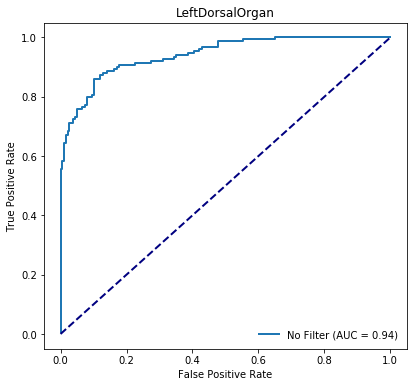

In [7]:
gt = {}
fpr = {}
tpr = {}
thresholds = {}
roc_auc = {}

train_data_pos = get_train_data(train_pos.copy())
train_data_neg = get_train_data(train_neg.copy())
detected_loc = {}
detected_loc['No Filter'] = predict_locations(train_data_pos, test_annotations)
# detected_loc['Distance Test'] = predict_locations_neg_pos(train_data_pos, train_data_neg, test_annotations)
# detected_loc['Ratio Test'] = predict_locations_ratio_test(train_data_pos, test_annotations)

fig_roc = plt.figure(figsize=(6.5, 6))
for test_name, test_val in detected_loc.iteritems():
    for bp in ['LeftDorsalOrgan']:
#         gt, fpr, tpr, thresholds, roc_auc = plot_roc_curve(coordinates, test_val, bp)
        gt, fpr, tpr, thresholds, roc_auc = plot_roc_curve_and(coordinates, test_val, no_anno_df)
        plt.plot(fpr, tpr, lw=2, label='%s (AUC = %0.2f)'%(test_name, roc_auc))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(bp)
plt.legend(loc="lower right", frameon=False)
plt.show()

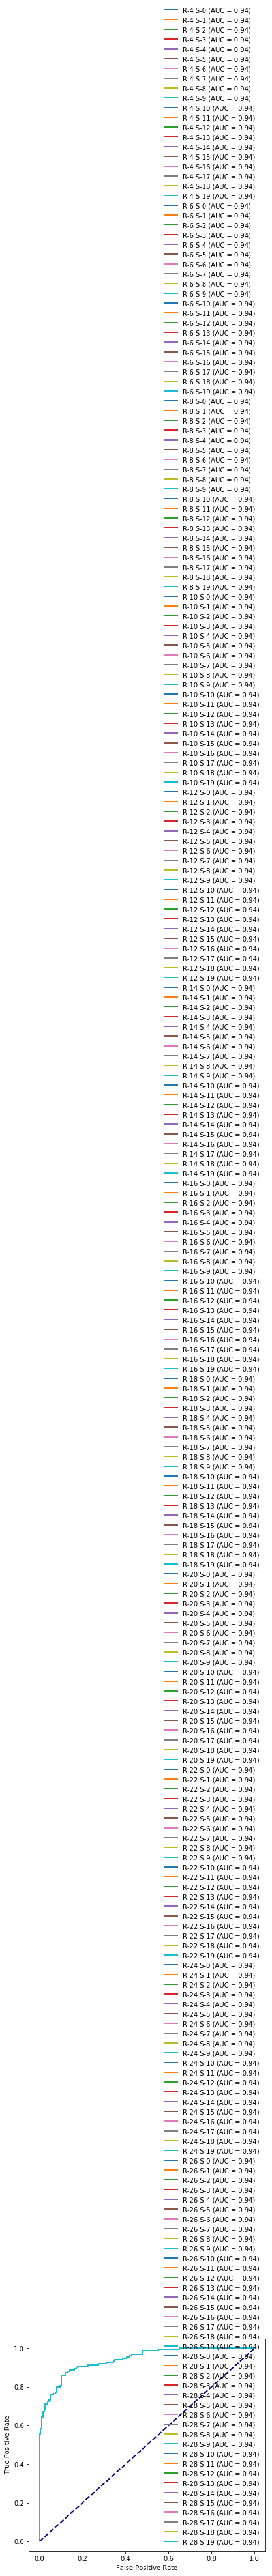

In [9]:
gt = {}
fpr = {}
tpr = {}
thresholds = {}
roc_auc = {}

train_data_pos = get_train_data(train_pos.copy())
train_data_neg = get_train_data(train_neg.copy())

fig_roc = plt.figure(figsize=(14, 12))
patch_sizes = np.arange(4, 30, 2)
patch_sigmas = np.arange(0.1, 20, 1)
detected_loc = {}
for vote_patch in patch_sizes:
    for vote_sigma in patch_sigmas:
        detected_loc = predict_locations_patchsize(train_data_pos, test_annotations, vote_patch, vote_sigma)
        gt, fpr, tpr, thresholds, roc_auc = plot_roc_curve_and(coordinates, detected_loc, no_anno_df)
        plt.plot(fpr, tpr, lw=2, label='R-%d S-%d (AUC = %0.2f)'%(vote_patch, vote_sigma, roc_auc))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt.title(bp)
plt.legend(loc="lower right", frameon=False)
plt.show()

In [ ]:
# temp_coordinates = all_coordinates.loc[:, all_coordinates.columns.values[::2]]
# total_negatives = temp_coordinates[temp_coordinates<0].count()
# total_positives = temp_coordinates[temp_coordinates>=0].count()
# posneg_df = pd.DataFrame([total_positives, total_negatives])
# posneg_df.columns = distance_header
# posneg_df.index = ['pos', 'neg']
# posneg_df

In [ ]:
# vote_patch_size = 30
# vote_sigma = 15
# bodypart_vote = np.zeros((2 * vote_patch_size + 1, 2 * vote_patch_size + 1), np.float)

# for x in range(-vote_patch_size, vote_patch_size + 1):
#     for y in range(-vote_patch_size, vote_patch_size + 1):
#         bodypart_vote[y + vote_patch_size, x + vote_patch_size] = np.exp(-0.5 * (
#             x * x + y * y) / (np.square(vote_sigma))) / (vote_sigma * np.sqrt(2 * np.pi))

# imgplot = plt.imshow(bodypart_vote, cmap="hot")
# plt.colorbar()